In [365]:
import pandas as pd
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, Normalize
import ruptures as rpt

import gzip
import json
import os
from datetime import datetime

from utils import running_mean

import seaborn as sns
sns.set_style("whitegrid")

# mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)




CHOSEN_CMAP = "viridis"
def _set_color_cycle(num_colors, cmap_name=CHOSEN_CMAP):
    colors = [plt.get_cmap(cmap_name)(i / (num_colors - 1)) for i in range(num_colors)]
    plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
    return colors


IMAGEDIR = "./images/scratch/"
DRYRUN = False
OPEN_SAVEDIMAGES = False
BURN_IN_PROP = 0.9

if not DRYRUN:
    os.makedirs(IMAGEDIR, exist_ok=True)

def _generate_filepath(name):
    filepath = os.path.join(IMAGEDIR, name)
    print(f"Saving file at: {filepath}")
    if os.path.exists(filepath):
        print(f"Warning: Overwriting existing file: {filepath}")
    return filepath

def savefig_fn(fig, name):
    filepath = _generate_filepath(name)
    if not DRYRUN:
        dir = os.path.dirname(filepath)
        if not os.path.exists(dir):
            os.makedirs(dir, exist_ok=True)
        fig.savefig(filepath, bbox_inches="tight")
        if OPEN_SAVEDIMAGES:
            os.system(f"open {filepath}")
    else:
        print("DRY RUN, figure not saved.")
    return


_to_array = lambda x: np.array(x)
COLUMN_TRANSFORM = {
    "component_potential_grad_norm": _to_array,
    "corrected_total_matrix": _to_array,
    "total_matrix": _to_array,
    "potential_matrix": _to_array,
}


def parse_sgd_logs(logs):
    print("Parsing SGD logs...")
    eval_names = logs["eval_list"]
    other_cols = None
    data = []
    for checkpoint in logs["checkpoint_logs"]:
        keys = sorted(checkpoint.keys())
        keys.remove("evals")
        if other_cols is None:
            other_cols = keys
        else:
            assert keys == other_cols
        checkpoint_data = [
            checkpoint[key] for key in keys
        ] + checkpoint["evals"]
        data.append(checkpoint_data)
    columns = other_cols + eval_names
    df = pd.DataFrame(data, columns=columns)
    print(f"Data shape: {df.shape}")
    # apply COLUMN_TRANSFORM
    for k, v in COLUMN_TRANSFORM.items():
        if k in df.columns:
            df[k] = df[k].apply(v)
    return df

def parse_gd_logs(logs):
    print("Parsing GD logs...")
    eval_names = logs["eval_list"]
    other_cols = None
    data = []
    for checkpoint in logs["checkpoint_logs"]:
        keys = sorted(checkpoint.keys())
        keys.remove("evals")
        if "total_matrix" in keys:
            keys.remove("total_matrix")
        if other_cols is None:
            other_cols = keys
        else:
            assert keys == other_cols, f"Keys: {keys}, other_cols: {other_cols}"
        checkpoint_data = [
            checkpoint[key] for key in keys
        ] + checkpoint["evals"]
        data.append(checkpoint_data)
    columns = other_cols + eval_names
    df = pd.DataFrame(data, columns=columns)
    print(f"Data shape: {df.shape}")
    for k, v in COLUMN_TRANSFORM.items():
        if k in df.columns:
            df[k] = df[k].apply(v)
    return df



def parse_individual_stagewise_gd_logs(logs):
    eval_names = logs["eval_lists"]
    eval_names = [name for name in eval_names if not name.startswith("stage_llc")]
    num_stages = logs["num_stages"]
    
    if num_stages != len(logs["stage_logs"]):
        print("Warning: num_stages does not match the number of stage logs.")
    other_cols = None
    data = []
    accumuated_time = 0
    other_info = {}
    for stage in range(num_stages):
        llc_key = f"stage_llc_{stage}"
        other_info[stage] = {}
        if llc_key in logs:
            other_info[stage]["llc"] = logs[llc_key]
        llc_potential_key = f"stage_llc_known_potential_{stage}"
        if llc_potential_key in logs:
            other_info[stage]["llc_potential"] = logs[llc_potential_key]
        

    for stage, stage_logs in enumerate(logs["stage_logs"]):
        for checkpoint in stage_logs:
            keys = sorted(checkpoint.keys())
            keys.remove("evals")
            if "total_matrix" in keys:
                keys.remove("total_matrix")
        
            if other_cols is None:
                other_cols = keys
            else:
                assert keys == other_cols, f"Keys: {keys}, other_cols: {other_cols}"
            checkpoint_data = (
                [checkpoint[key] for key in keys] 
                + checkpoint["evals"] 
                + [stage, num_stages, checkpoint["t"] + accumuated_time]
            )
            data.append(checkpoint_data)
        accumuated_time += stage_logs[-1]["t"]
    columns = other_cols + eval_names + ["stage", "num_stages", "total_time"]
    df = pd.DataFrame(data, columns=columns)
    print(f"Data shape: {df.shape}")
    for k, v in COLUMN_TRANSFORM.items():
        if k in df.columns:
            df[k] = df[k].apply(v)
    return df, other_info

def parse_stagewise_gd_logs(logs):
    print("Parsing Stagewise GD logs...")
    results = {}
    for potential_type, potential_logs in logs.items():
        print(f"Parsing GD logs for stagewise potential type: {potential_type}")
        df, other_info = parse_individual_stagewise_gd_logs(potential_logs)
        results[potential_type] = {
            "df": df,
            "other_info": other_info,
        }
        
    return results


def group_values_by_resolution(values, resolution):
    if not values:
        return []

    sorted_indices = sorted(range(len(values)), key=lambda i: values[i])
    sorted_values = [values[i] for i in sorted_indices]

    groups = []
    current_group = [sorted_indices[0]]
    group_start_value = sorted_values[0]

    for i in range(1, len(sorted_values)):
        if sorted_values[i] - group_start_value >= resolution:
            groups.append(current_group)
            current_group = []
            group_start_value = sorted_values[i]
        current_group.append(sorted_indices[i])

    # Add the last group
    if current_group:
        groups.append(current_group)

    # Sort indices within each group
    return [sorted(group) for group in groups]


# Query Directory or Database and Parse Data

In [15]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['test_dln_stagewise_learning']
collection = db['runs']

EXPT_NAME = "test_run"

query = {
    # "config.expt_name": EXPT_NAME, 
    # "status": "COMPLETED", 
    # "_id": 24 # init origin
    # "_id": 29 # init away from origin 
    "_id": 46
}
expt_info = collection.find_one(query)["info"]
expt_config = collection.find_one(query)["config"]
expt_properties = expt_info["expt_properties"]

df_sgd = parse_sgd_logs(expt_info["sgd_logs"])
df_gd = parse_gd_logs(expt_info["gd_logs"])
stagewise_dfs = parse_stagewise_gd_logs(expt_info["stagewise_gd_logs"])


Parsing SGD logs...
Data shape: (556, 19)
Parsing GD logs...
Data shape: (371, 14)
Parsing Stagewise GD logs...
Parsing GD logs for stagewise potential type: block
Data shape: (489, 11)
Parsing GD logs for stagewise potential type: diag
Data shape: (153, 11)
Parsing GD logs for stagewise potential type: col
Data shape: (566, 11)
Parsing GD logs for stagewise potential type: row
Data shape: (574, 11)
Parsing GD logs for stagewise potential type: corner
Data shape: (487, 11)
Parsing GD logs for stagewise potential type: offdiag_inclusive
Data shape: (24514, 12)
Parsing GD logs for stagewise potential type: offdiag_exclusive
Data shape: (3871, 12)
Parsing GD logs for stagewise potential type: row_col
Data shape: (126, 11)


In [613]:

# _ID = 24 # band, dim=12
# _ID = 25 # band, dim=18
# _ID = 27 # band, dim=18, num_chains=3
# _ID = 31 # band, dim=21, num_chains=5, num_steps=1000, epsilon=2e-8, num_steps=300k
# _ID = 32 # band, dim=21, num_chains=5, num_steps=800, epsilon=5e-8, num_steps=500k
# _ID = 33 # band, dim=21, num_chains=5, num_steps=500, epsilon=5e-8, num_steps=350k
# _ID = 34 # band, dim=21, num_chains=5, num_steps=500, epsilon=5e-8, num_steps=350k, init=-0.5
# _ID = 35 # band, dim=21, num_chains=5, num_steps=500, epsilon=5e-8, num_steps=350k, init=0.5
# _ID = 36 # band, dim=21, num_chains=5, num_steps=1500, epsilon=2e-8, num_steps=350k, init=2, (band, 2.0, 5.0, 2)
# _ID = 37 # band, dim=21, num_chains=5, num_steps=2500, epsilon=2e-8, num_steps=320k, init=2, (band, 2.0, 5.0, 2)
# _ID = 38 # band, dim=21, num_chains=5, num_steps=3500, epsilon=2e-8, num_steps=320k, init=2, (band, 2.0, 5.0, 2), log_checkpoint_params=True, logging_period=800
# _ID = 42 # band, dim=21, num_chains=8, num_steps=5000, epsilon=2e-8, num_steps=320k, init=2, (band, 2.0, 5.0, 2), log_checkpoint_params=False, logging_period=500
# _ID = 41 # band, dim=21, num_chains=5, num_steps=3000, epsilon=2e-8, num_steps=600k, init=2.5, (band, 2.0, 5.0, 2), log_checkpoint_params=False, logging_period=1000, hidden_layers=[21,21]
# _ID = 47 # band, dim=21, num_chains=5, num_steps=3000, epsilon=2e-8, num_steps=800k, init=2., (band, 2.0, 5.0, 2), log_checkpoint_params=False, logging_period=1200, hidden_layers=[21,21,21]
# _ID = 48 # band, dim=21, num_chains=5, num_steps=3000, epsilon=2e-8, num_steps=800k, init=2., (band, 1.0, 10.0, 2), log_checkpoint_params=False, logging_period=1200, hidden_layers=[21,21]
_ID = 49 # band, dim=21, num_chains=5, num_steps=3000, epsilon=2e-8, num_steps=1M, init=2., (band, 1.0, 10.0, 2), log_checkpoint_params=False, logging_period=1200, hidden_layers=[21,21,21]


# _ID = 50 # diag, dim=5, num_chains=5, num_steps=2000, epsilon=2e-8, num_steps=100k, init=2., (diag, 50, 10), log_checkpoint_params=False, logging_period=200, model=[5, 5, 5, 5]
# _ID = 51 # diag, dim=5, num_chains=5, num_steps=4000, epsilon=1e-8, num_steps=100k, init=1.5, (diag, 50, 10), log_checkpoint_params=False, logging_period=500, model=[5, 20, 20, 5]


# DATA_DIR = f"./outputs/test/{_ID}/"
# IMAGEDIR = f"./images/test/{_ID}/"


_ID = 10
DATA_DIR = (
    "./spartan_outputs/"
    # "dln_stagewise_learning/prod/dln_small_width8-15_layers1-5_in8_out8_n100000_bs512_lr1e-05_nstep500000_optimsgd_202409181118/11/"
    # f"dln_stagewise_learning/prod/dln_banded_large_width256-300_layers1-3_in256_out256_n100000_bs512_lr0.0001_nstep500000_optimsgd_llcTrue_202409250017/{_ID}/"
    # f"dln_stagewise_learning/prod/dln_banded_large_width256-300_layers1-2_in256_out256_n100000_bs1024_lr0.0001_nstep500000_optimsgd_llcTrue_202409251353/{_ID}/"
    # f"dln_stagewise_learning/prod/dln_banded_large_width256-800_layers2-4_in256_out256_n100000_bs1024_lr0.0002_nstep800000_optimsgd_llcTrue_202409252145/{_ID}/"
    f"dln_stagewise_learning/failed/dln_banded_large_width256-800_layers1-2_in256_out256_n100000_bs1024_lr0.0002_nstep800000_optimsgd_llcTrue_202409261848/{_ID}/"
)
IMAGEDIR = f"./images/spartan/prod/{_ID}/"


def _read_json_file(filepath):
    assert filepath.endswith(".json") or filepath.endswith(".json.gz")
    if filepath.endswith(".json"):
        with open(filepath, "r") as f:
            data = json.load(f)
    else:
        with gzip.open(filepath, "rb") as f:
            data = json.load(f)
    return data

def extract_directory(dir_path):
    filelist = os.listdir(dir_path)
    print(f"Extracting directory: {dir_path}. Found {len(filelist)} files: \n   {filelist}")
    config_filename = "config.json" if "config.json" in filelist else "config.json.gz"
    info_filename = "info.json" if "info.json" in filelist else "info.json.gz"
    expt_config = _read_json_file(os.path.join(dir_path, config_filename))
    expt_info = _read_json_file(os.path.join(dir_path, info_filename))
    expt_properties = expt_info["expt_properties"]

    df_sgd = parse_sgd_logs(expt_info["sgd_logs"])
    df_gd = parse_gd_logs(expt_info["gd_logs"])
    stagewise_dfs = parse_stagewise_gd_logs(expt_info["stagewise_gd_logs"])
    return expt_config, expt_info, expt_properties, df_sgd, df_gd, stagewise_dfs

expt_config, expt_info, expt_properties, df_sgd, df_gd, stagewise_dfs = extract_directory(DATA_DIR)
# df_sgd = df_sgd[df_sgd["t"] < 300000]

do_llc_estimation = expt_config["do_llc_estimation"]
input_dim = expt_config["model_config"]["input_dim"]
output_dim = expt_config["model_config"]["output_dim"]
teacher_matrix = np.array(expt_properties["teacher_matrix"])
input_correlation_matrix = np.array(expt_properties["input_correlation_matrix"])
input_output_correlation_matrix = np.array(expt_properties["input_output_cross_correlation_matrix"])
U, S, V, Vhat, ChangeOfBasis = [
    np.array(expt_properties["svd_matrices"][key]) for key in [
        "U", "S", "V", "Vhat", "ChangeOfBasis"
    ]
]
stage_potential_types = list(stagewise_dfs.keys())
eval_mode = expt_config["eval_mode"]
num_modes = min(input_dim, output_dim)
expt_config

Extracting directory: ./spartan_outputs/dln_stagewise_learning/failed/dln_banded_large_width256-800_layers1-2_in256_out256_n100000_bs1024_lr0.0002_nstep800000_optimsgd_llcTrue_202409261848/10/. Found 5 files: 
   ['metrics.json.gz', 'info.json.gz', 'config.json.gz', 'cout.txt.gz', 'run.json.gz']
Parsing SGD logs...
Data shape: (667, 14)
Parsing GD logs...
Data shape: (668, 8)
Parsing Stagewise GD logs...
Parsing GD logs for stagewise potential type: block
Data shape: (47855, 262)


{'burn_in_prop': 0.9,
 'data_config': {'feature_map': None,
  'idcorr': True,
  'input_variance_range': [0.5, 2.5],
  'num_training_data': 100000,
  'output_noise_std': 0.1,
  'teacher_matrix': {'config_vals': '[5.0,1.05,2,300]',
   'type': 'band_power_law'}},
 'do_llc_estimation': True,
 'do_plotting': False,
 'eval_mode': 'minimal',
 'expt_name': 'dln_banded_large_width256-800_layers1-2_in256_out256_n100000_bs1024_lr0.0002_nstep800000_optimsgd_llcTrue_202409261848',
 'gd_training_config': {'early_stopping_epsilon': 0.0005,
  'learning_rate': 5e-05,
  'min_num_steps': 2000,
  'num_steps': 800000},
 'itemp': None,
 'log_full_checkpoint_param': False,
 'logging_period': 1200,
 'loss_trace_minibatch': True,
 'model_config': {'hidden_layer_widths': [771, 559],
  'init_origin': True,
  'initialisation_exponent': 2.0,
  'input_dim': 256,
  'output_dim': 256},
 'seed': 2,
 'sgld_config': {'batch_size': 512,
  'epsilon': 2e-08,
  'gamma': 1.0,
  'num_chains': 5,
  'num_steps': 2000},
 'traini

# SGD Training

(667, 14) 45
(667, 14) 90
(667, 14) 130
(667, 14) 160
(667, 14) 220
(667, 14) 290
(667, 14) 375
(667, 14) 667
Saving file at: ./images/spartan/prod/10/sgd_analysis.pdf


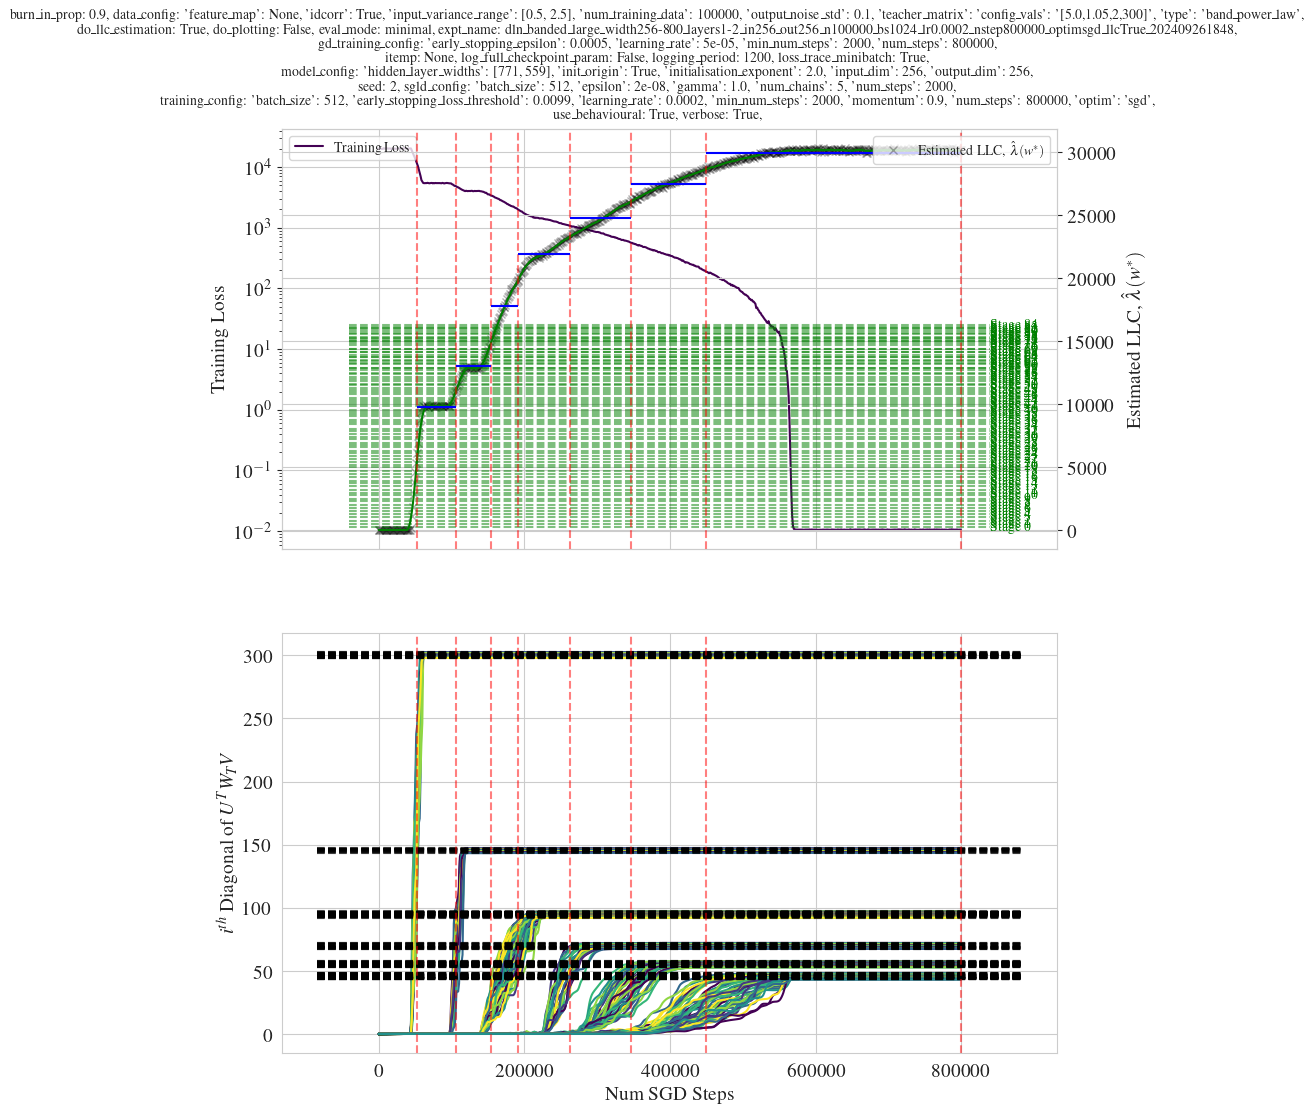

In [614]:
df = df_sgd
# df = df[df["t"] < 350000]
# df = df[df["t"] > 100]

num_plots = 2
if eval_mode == "full":
    num_plots += 2

fig, axes = plt.subplots(num_plots, 1, figsize=(10, 6 * num_plots), sharex=True)
ax = axes[0]
ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.set_ylabel("Training Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")

if do_llc_estimation:
    ax = ax.twinx()
    clipped_llc = np.clip(df["lambdahat"], a_min=0, a_max=1e6)
    ax.plot(df["t"], clipped_llc, "kx", alpha=0.3, label="Estimated LLC, $\hat{\lambda}(w^*)$")
    yvals = running_mean(clipped_llc)
    ax.plot(df["t"], yvals, "g-")
    ax.set_ylabel("Estimated LLC, $\hat{\lambda}(w^*)$")
    ax.legend(loc="upper right")

    CHOSEN_POTENTIAL_TYPE = "block" # "block", "row_col", "diag"
    llc_rec_block = stagewise_dfs[CHOSEN_POTENTIAL_TYPE]["other_info"]
    df_llc = pd.DataFrame.from_dict(llc_rec_block, orient="index").sort_index()
    xmin, xmax = ax.get_xlim()
    for stage in range(df_llc.shape[0]):
        llc = df_llc.loc[stage, "llc"]
        ax.hlines(llc, xmin, xmax, color="g", linestyle="--", alpha=0.5)
        ax.text(xmax, llc, f"Stage {stage}", color="g", fontsize=10, va="center")


        # llc_known_potential = df_llc.loc[stage, "llc_potential"]
        # if llc_known_potential < df_llc["llc"].max() + df_llc["llc"].mean():
        #     ax.hlines(llc_known_potential, xmin, xmax, color="r", linestyle="--", alpha=0.5)
        #     ax.text(xmax, llc_known_potential, f"Stage {stage}", color="r", fontsize=10, va="center")

    algo = rpt.Pelt(model="rbf").fit(np.array(clipped_llc.values))
    change_points = algo.predict(pen=5)
    for i, cp in enumerate(change_points):
        print(df.shape, cp)
        cp_prev = change_points[max(0, i - 1)]
        cp_prev_t = df["t"].iloc[cp_prev - 1]
        cp_t = df["t"].iloc[cp-1]
        mean_val = np.mean(clipped_llc[cp_prev:cp])
        ax.axvline(cp_t, color="r", linestyle="--", alpha=0.5)
        ax.hlines(mean_val, cp_prev_t, cp_t, color="b", linestyle="-", alpha=1)
else:
    change_points = None



ax = axes[1]
key = "corrected_total_matrix_diagonals"
for i in range(min(input_dim, output_dim)):
    ax.plot(
        df["t"],
        df[key].apply(lambda x: x[i]), 
        label="$s_{" + str(i + 1) + "}$"
    )

xmin, xmax = ax.get_xlim()
singvals_true = S
ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--", alpha=0.5)
ax.set_ylabel("$i^{th}$ Diagonal of $U^T W_T V$")

if change_points is not None:
    for cp in change_points:
        ax.axvline(df["t"].iloc[cp-1], color="r", linestyle="--", alpha=0.5)



if eval_mode == "full":
    ax = axes[2]
    for i in range(input_output_correlation_matrix.shape[0]):
        yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, i]**2)
        ax.plot(df["t"], yvals, label=f"({i}, {i})")
    ax.set_ylabel("$h_{i=j}(w_t)^2$")
    ax.set_title("Diagonal $h_{i=j}(w_t)^2$")
    ax.legend()
    ax.set_yscale("log")

    ax = axes[3]
    for i in range(input_output_correlation_matrix.shape[0]):
        for j in range(input_output_correlation_matrix.shape[1]):
            if i == j: continue # only plot the off diagonal elements
            yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, j]**2)
            ax.plot(df["t"], yvals, label=f"({i}, {j})")
    ax.set_ylabel("$h_{i \\neq j}(w_t)^2$")
    ax.set_title("Off diagonal $h_{i \\neq j}(w_t)^2$")
    ax.set_yscale("log")
    # ax.legend()



for i, ax in enumerate(axes): 
    if i == len(axes) - 1:
        ax.set_xlabel("Num SGD Steps")
    # ax.set_yscale("log")
    # ax.set_xscale("log")


suptitle = ""
for k, v in expt_config.items():
    suptitle += f"{k}: {v}, "
    if len(suptitle.split("\n")[-1]) > 80:
        suptitle += "\n"
fig.suptitle(suptitle, fontsize=10)

savefig_fn(fig, "sgd_analysis.pdf")


In [615]:

import ast
teach_matrix_config_vals = ast.literal_eval(
    expt_config["data_config"]["teacher_matrix"]["config_vals"]
)
resolution = teach_matrix_config_vals[0]
values = list([float(val) for val in singvals_true])

result = group_values_by_resolution(values, resolution)
for i, group in enumerate(result):
    print(f"Group {i + 1}: {[f'{values[j]:.1f}' for j in group]}")

Group 1: ['48.2', '48.1', '48.1', '48.0', '47.9', '47.5', '47.5', '47.1', '47.0', '47.0', '47.0', '47.0', '46.9', '46.9', '46.8', '46.7', '46.6', '46.5', '46.4', '46.2', '46.1', '45.9', '45.5', '45.4', '45.3', '45.3', '45.2', '45.2', '45.2', '45.2', '44.9', '44.9', '44.8', '44.6', '44.6', '44.5', '44.4', '44.3', '44.3', '44.2', '44.1', '44.1', '44.1', '44.1', '44.0', '44.0', '43.8', '43.7', '43.6', '43.6', '43.4', '43.4', '43.3', '43.2']
Group 2: ['57.8', '57.7', '57.6', '57.3', '57.2', '57.2', '57.1', '57.1', '57.0', '56.7', '56.7', '56.6', '56.6', '56.5', '56.5', '56.2', '56.2', '56.0', '56.0', '55.8', '55.6', '55.3', '55.2', '55.1', '55.0', '55.0', '55.0', '54.8', '54.7', '54.7', '54.6', '54.6', '54.5', '54.3', '54.2', '54.1', '53.8', '53.7', '53.6', '53.5', '53.2', '53.0', '52.9', '52.9', '52.9']
Group 3: ['72.1', '72.0', '71.7', '71.6', '71.6', '71.1', '70.6', '70.2', '70.0', '69.8', '69.4', '69.2', '69.1', '68.9', '68.9', '68.6', '68.3', '68.2', '67.9', '67.8', '67.6', '67.6', '6

Saving file at: ./images/spartan/prod/10/sgd_stagewise_potential_block.pdf
Saving file at: ./images/spartan/prod/10/sgd_stagewise_potential_diag.pdf
Saving file at: ./images/spartan/prod/10/sgd_stagewise_potential_row_col.pdf


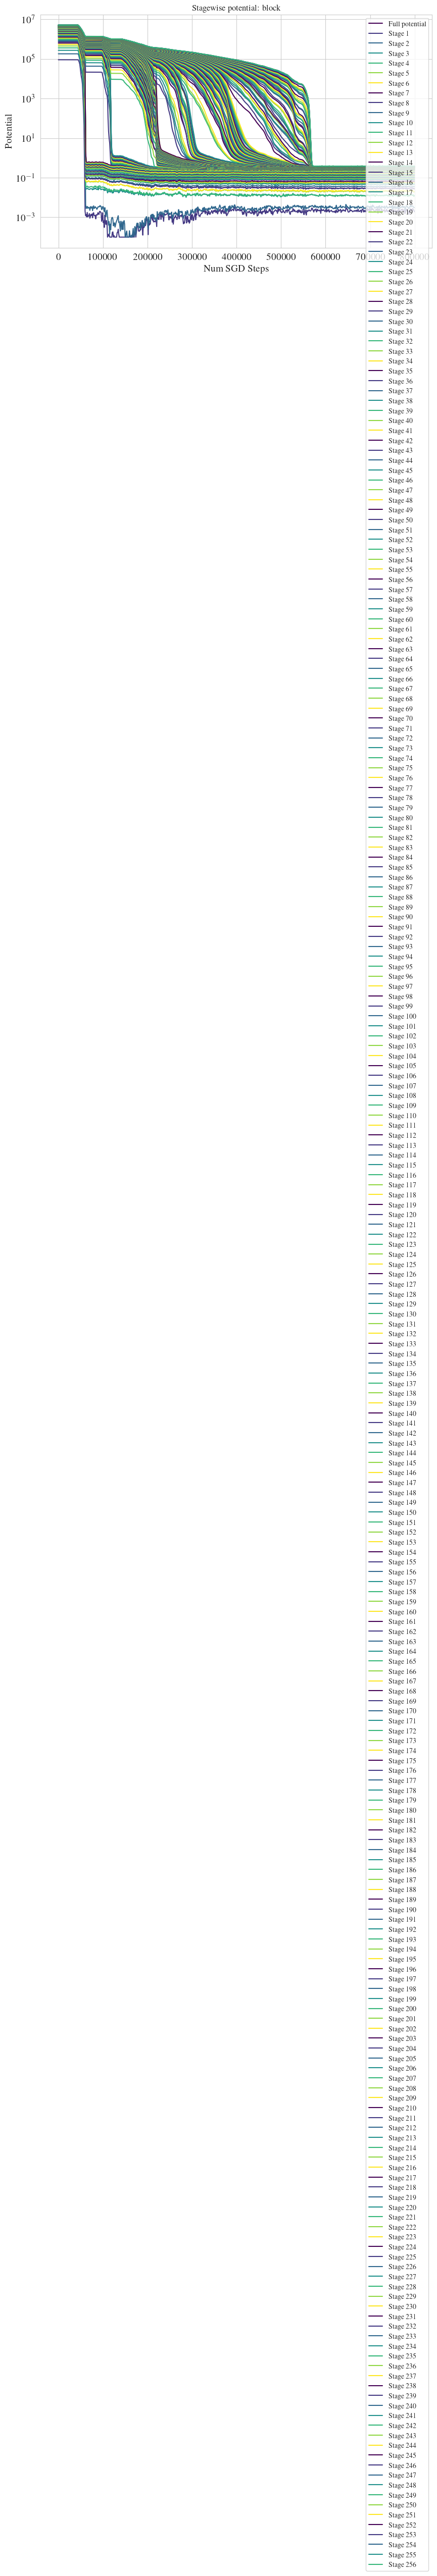

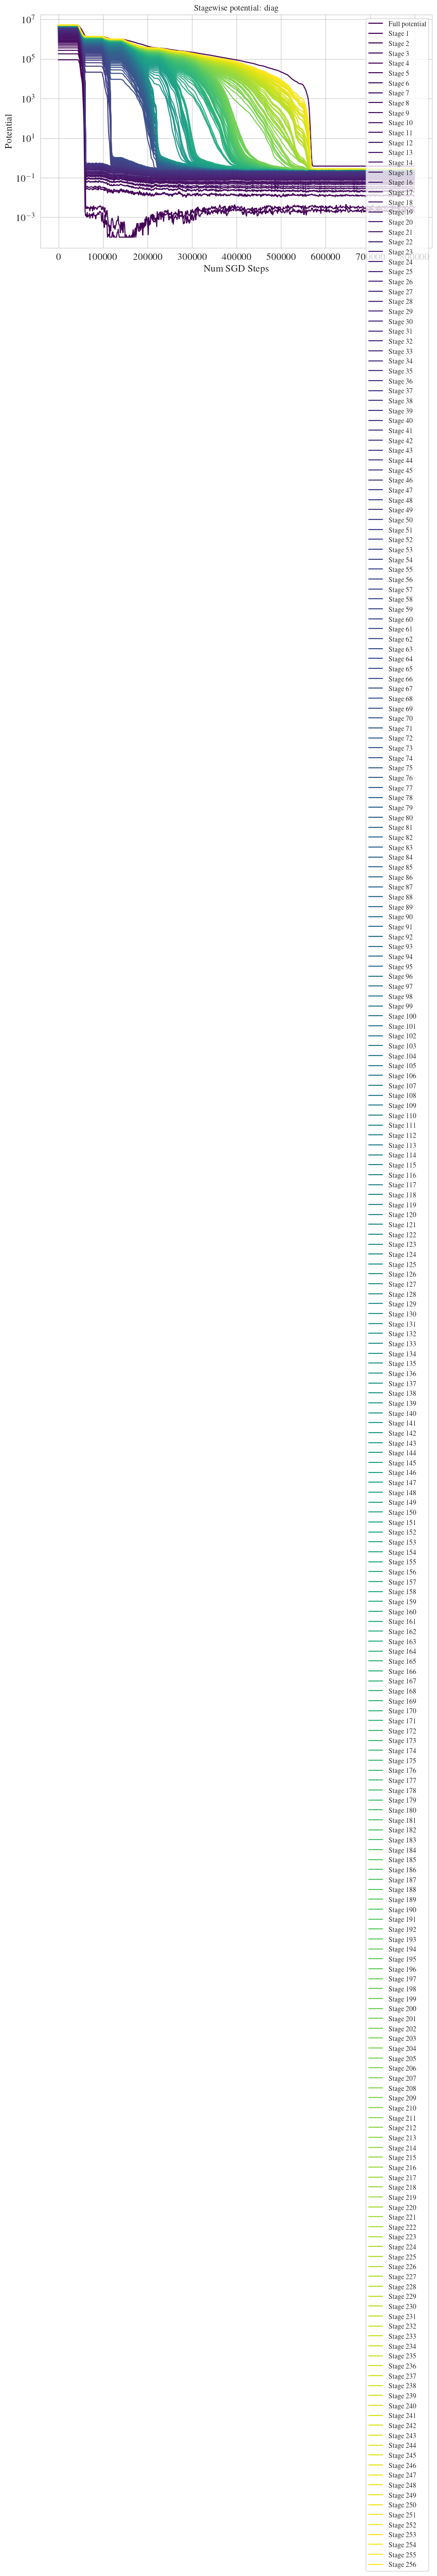

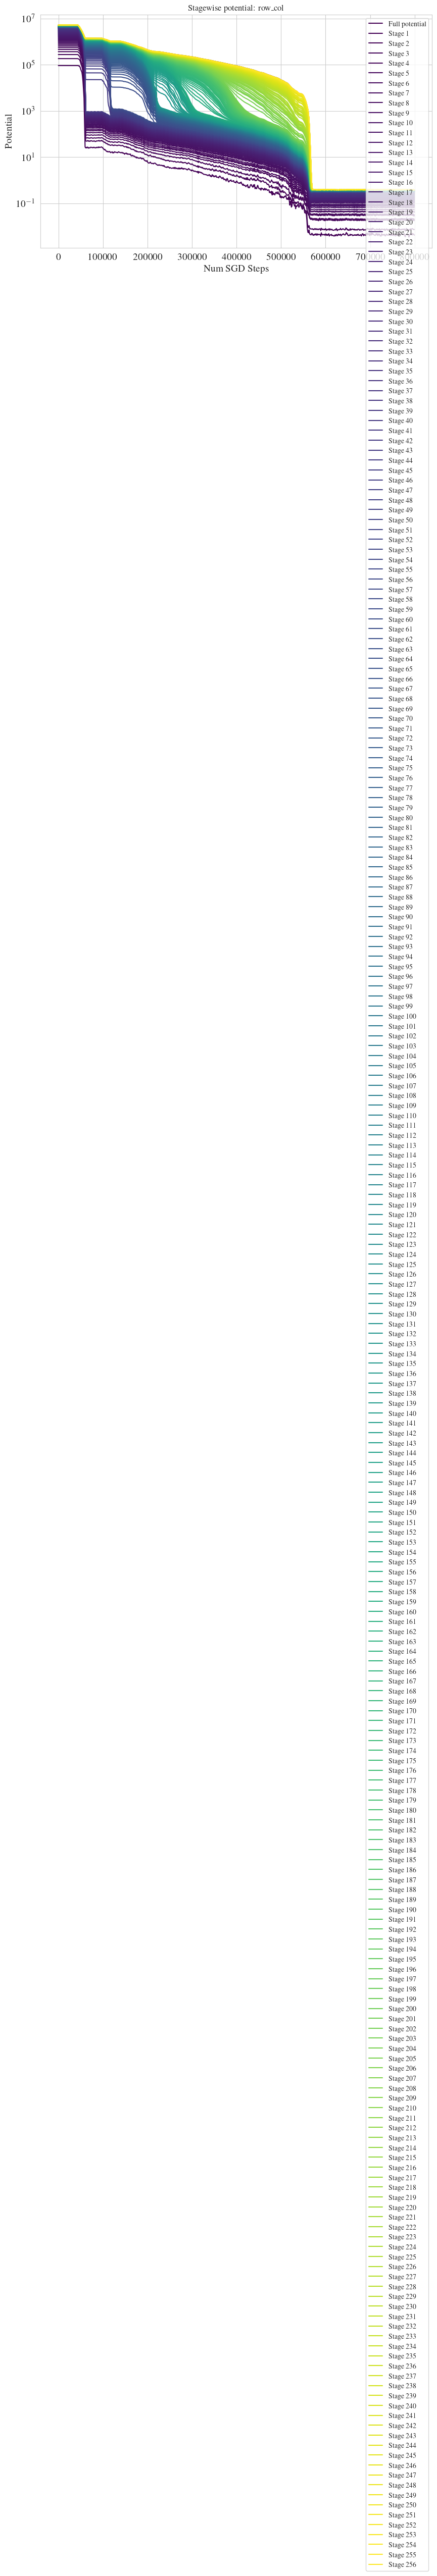

In [616]:
df = df_sgd
cols = [col for col in df.columns if col.startswith("stage_potential")]
ymin_bound = 1e-4
for col in cols:
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    values = np.array(df[col].tolist())
    values = np.clip(values, a_min=ymin_bound, a_max=np.inf)
    name = col.split('=')[-1]
    _set_color_cycle(values.shape[1] + 1)
    ax.plot(df["t"], df["full_potential"], label="Full potential")
    for stage in range(values.shape[1]):
        ax.plot(df["t"], values[:, stage], label=f"Stage {stage + 1}")
    ax.set_xlabel("Num SGD Steps")
    ax.set_ylabel("Potential")
    ax.set_yscale("log")
    ax.legend()
    ax.set_title(f"Stagewise potential: {name}")

    savefig_fn(fig, f"sgd_stagewise_potential_{name}.pdf")

# GD Training

Saving file at: ./images/spartan/prod/10/gd_analysis.pdf


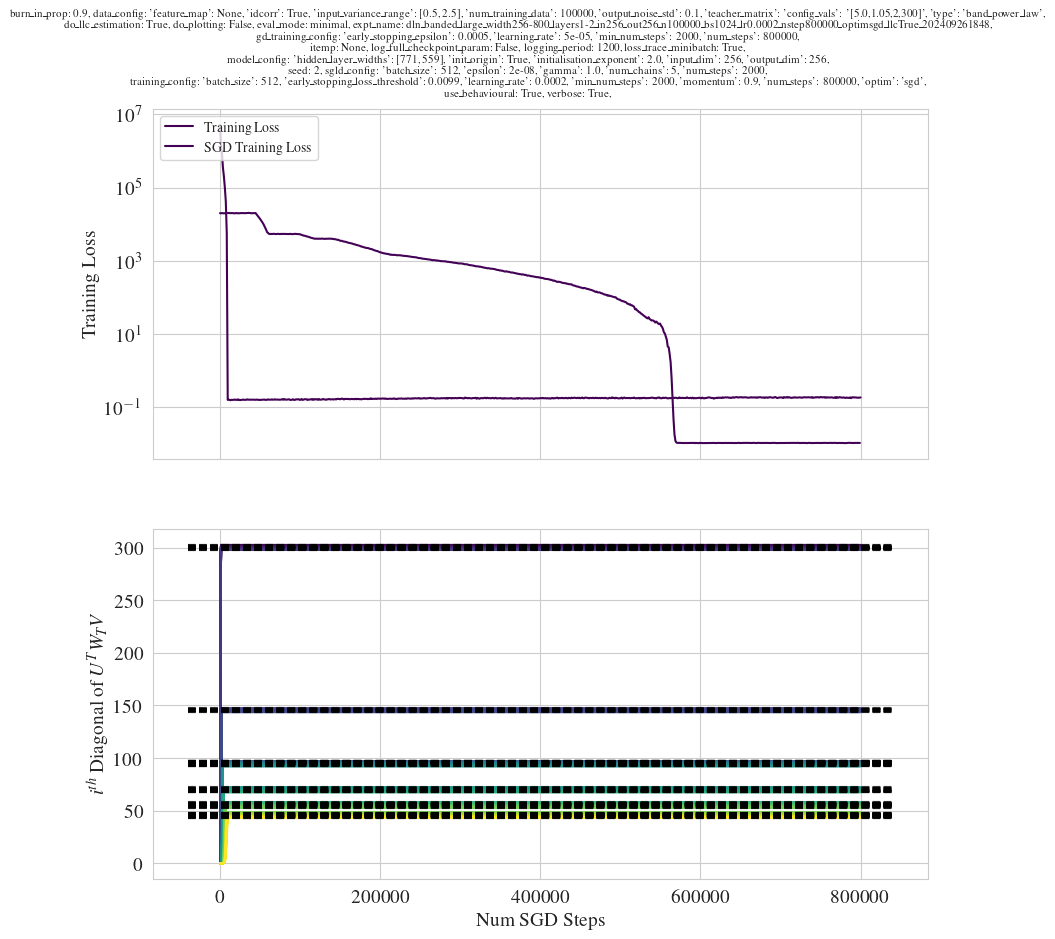

In [617]:
df = df_gd

num_plots = 2
if eval_mode == "full":
    num_plots += 2
fig, axes = plt.subplots(num_plots, 1, figsize=(10, 5 * num_plots), sharex=True)

ax = axes[0]
ax.plot(df["t"], df["loss"], label="Training Loss")
ax.plot(df_sgd["t"], df_sgd["train_loss"], label="SGD Training Loss")
ax.set_ylabel("Training Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")

ax = axes[1]
key = "corrected_total_matrix_diagonals"
for i in range(min(input_dim, output_dim)):
    ax.plot(
        df["t"],
        df[key].apply(lambda x: x[i]), 
        label="$s_{" + str(i + 1) + "}$"
    )

xmin, xmax = ax.get_xlim()
singvals_true = S
ax.hlines(singvals_true, xmin, xmax, color="k", linestyle="--", alpha=0.5)
ax.set_ylabel("$i^{th}$ Diagonal of $U^T W_T V$")


if eval_mode == "full":
    ax = axes[1]
    for i in range(input_output_correlation_matrix.shape[0]):
        yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, i]**2)
        ax.plot(df["t"], yvals, label=f"({i}, {i})")
    ax.set_ylabel("$h_{i=j}(w_t)^2$")
    ax.set_title("Diagonal $h_{i=j}(w_t)^2$")
    ax.legend()
    ax.set_yscale("log")

    ax = axes[2]
    for i in range(input_output_correlation_matrix.shape[0]):
        for j in range(input_output_correlation_matrix.shape[1]):
            if i == j: continue # only plot the off diagonal elements
            yvals = df["potential_matrix"].apply(lambda x: np.array(x)[i, j]**2)
            ax.plot(df["t"], yvals, label=f"({i}, {j})")
    ax.set_ylabel("$h_{i \\neq j}(w_t)^2$")
    ax.set_title("Off diagonal $h_{i \\neq j}(w_t)^2$")
    ax.set_yscale("log")
    # ax.legend()



for i, ax in enumerate(axes): 
    if i == len(axes) - 1:
        ax.set_xlabel("Num SGD Steps")

fig.suptitle(suptitle, fontsize=8)
savefig_fn(fig, "gd_analysis.pdf")

# Stagewise Training

Saving file at: ./images/spartan/prod/15/stagewise_training_potential_block.pdf
Saving file at: ./images/spartan/prod/15/stagewise_training_potential_diag.pdf
Saving file at: ./images/spartan/prod/15/stagewise_training_potential_row_col.pdf


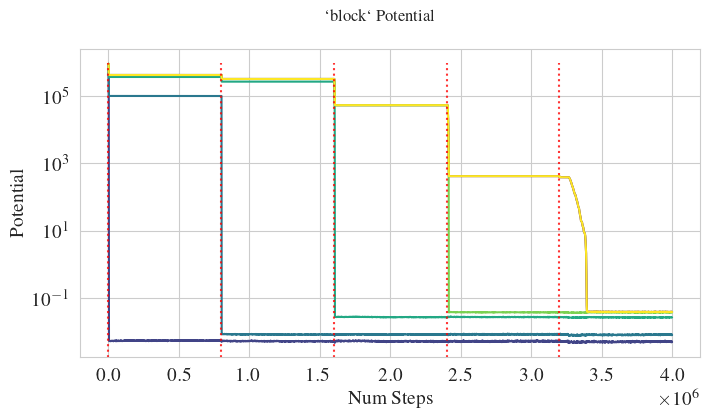

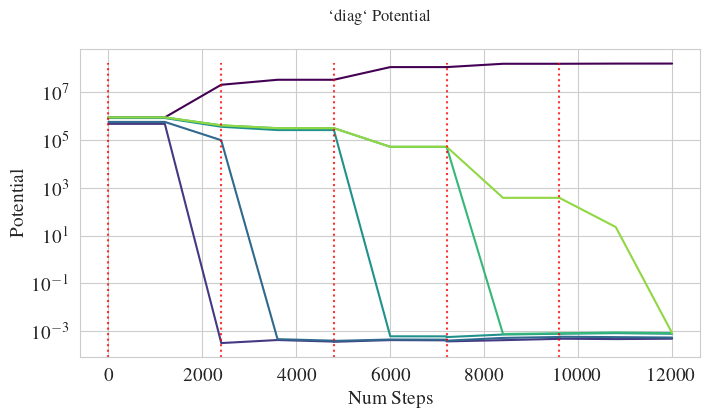

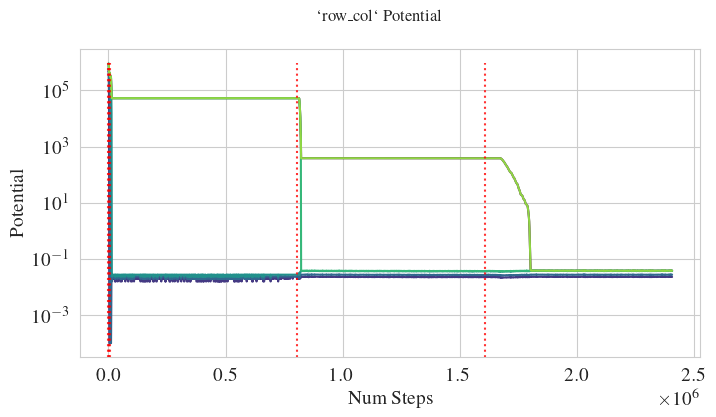

In [594]:
ymin_bound = 1e-4
# ymin_bound = -np.inf
for potential_type, rec in stagewise_dfs.items():
    df = rec["df"]
    other_info = rec["other_info"]
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))

    cols = ["total_potential"] + [col for col in df.columns if col.startswith("stage_potential")]
    _set_color_cycle(len(cols) + 1)
    for col in cols:
        yvals = np.clip(df[col], a_min=ymin_bound, a_max=np.inf)
        ax.plot(df["total_time"], yvals, label=col)

    stage_boundaries = df.groupby("stage")["total_time"].min().values
    ymin, ymax = ax.get_ylim()
    ax.vlines(stage_boundaries, ymin, ymax, color="r", linestyle="dotted", alpha=0.8)

    ax.set_xlabel("Num Steps")
    ax.set_ylabel("Potential")

    ax.set_yscale("log")
    # ax.set_xscale("log")
    # ax.legend()
    fig.suptitle(f"`{potential_type}` Potential")

    savefig_fn(fig, f"stagewise_training_potential_{potential_type}.pdf")

Saving file at: ./images/spartan/prod/15/stagewise_llc_block.pdf
Saving file at: ./images/spartan/prod/15/stagewise_llc_diag.pdf
Saving file at: ./images/spartan/prod/15/stagewise_llc_row_col.pdf


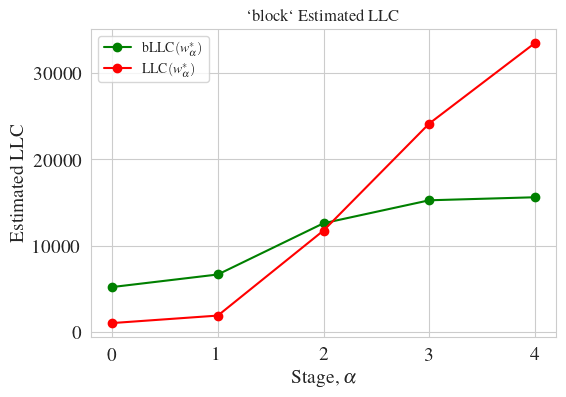

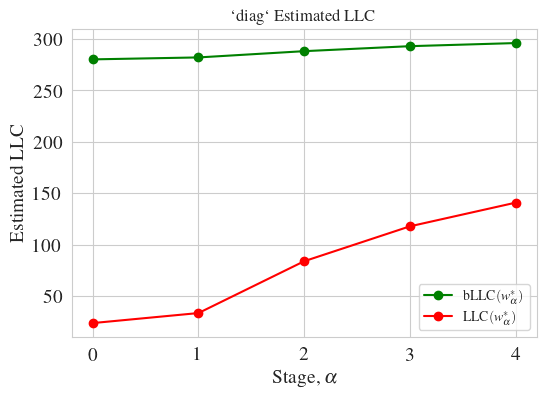

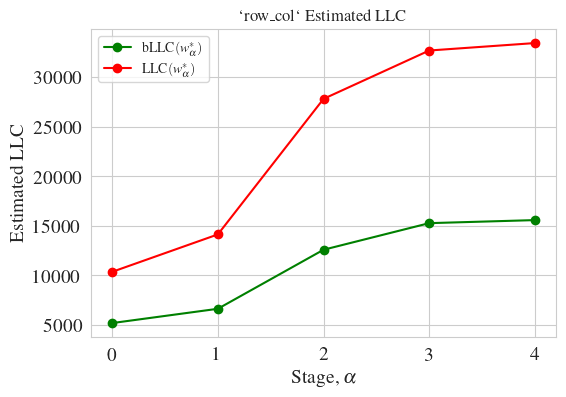

In [595]:
for potential_type, rec in stagewise_dfs.items():
    llc_rec = stagewise_dfs[potential_type]["other_info"]
    df = pd.DataFrame.from_dict(llc_rec, orient="index")
    clip_val = df["llc"].max() + df["llc"].mean()
    clip_val = np.inf
    df = df.clip(upper=clip_val, lower=0)
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(df.index, df["llc"], "go-", label="$\mathrm{bLLC}(w^*_\\alpha)$")
    ax.plot(df.index, df["llc_potential"], "ro-", label="$\mathrm{LLC}(w^*_\\alpha)$")
    ax.set_xlabel("Stage, $\\alpha$")
    ax.set_ylabel("Estimated LLC")
    ax.set_title(f"`{potential_type}` Estimated LLC")
    ax.legend()

    savefig_fn(fig, f"stagewise_llc_{potential_type}.pdf")

Detected change points: [40, 45, 90, 125, 145, 165, 210, 265, 320, 395, 667]
Detected change points: [50, 185, 255, 345, 465, 667]
Saving file at: ./images/spartan/prod/10/sgd_and_rank_change_points.pdf


/Users/edmund/.local/share/virtualenvs/neural_network_stagewise_learning-iEdHgy9r/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/edmund/.local/share/virtualenvs/neural_network_stagewise_learning-iEdHgy9r/lib/python3.11/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


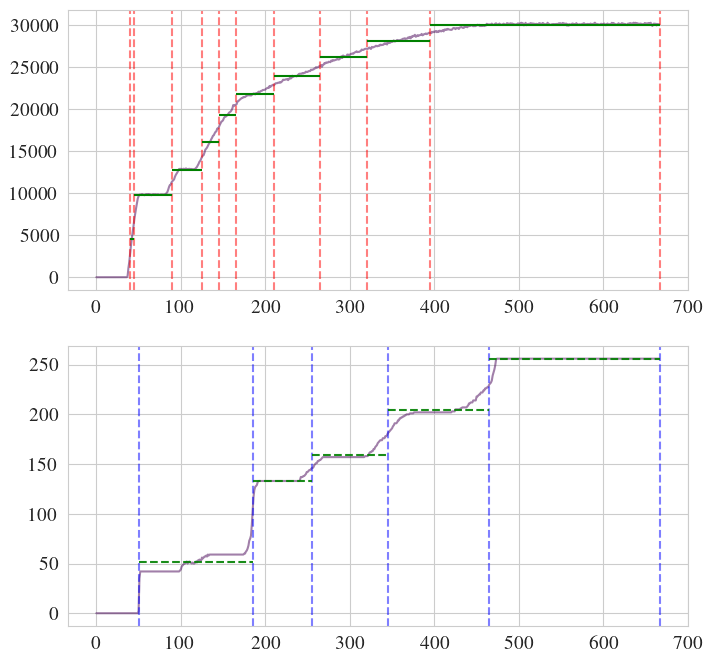

In [618]:
df = df_sgd
clipped_llc = df["lambdahat"].values[:]
algo = rpt.Pelt(model="rbf").fit(clipped_llc)
change_points = algo.predict(pen=2)
print(f"Detected change points: {change_points}")

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
ax = axes[0]
ax.plot(clipped_llc, label="Estimated LLC", alpha=0.5)
for i, cp in enumerate(change_points):
    ax.axvline(cp, color="r", linestyle="--", alpha=0.5)
    cp_prev = change_points[max(0, i - 1)]
    mean_val = np.mean(clipped_llc[cp_prev:cp])
    ax.hlines(mean_val, cp_prev, cp, color="g", linestyle="-", alpha=1)

ax = axes[1]
rs = df["corrected_total_matrix_diagonals"].map(
    lambda x: np.sum(np.abs(np.array(x) - S) < 0.2)
).values
ax.plot(rs, alpha=0.5)
algo = rpt.Pelt(model="rbf").fit(rs)
change_points = algo.predict(pen=5)
print(f"Detected change points: {change_points}")
for i, cp in enumerate(change_points):
    ax.axvline(cp, color="b", linestyle="--", alpha=0.5)
    cp_prev = change_points[max(0, i - 1)]
    mean_val = np.mean(rs[cp_prev:cp])
    ax.hlines(mean_val, xmin=cp_prev, xmax=cp, color="g", linestyle="--", alpha=0.9)

savefig_fn(fig, "sgd_and_rank_change_points.pdf")

# MISC

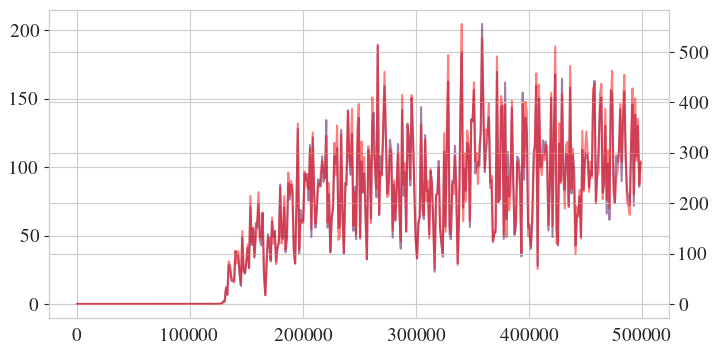

In [560]:
df = df_sgd
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(df["t"], df["lambdahat_std"], alpha=0.5)

df["lambdahat_range"] = df["lambdahat_list"].apply(lambda x: np.max(x) - np.min(x))

ax = ax.twinx()
ax.plot(df["t"], df["lambdahat_range"], "r-", alpha=0.5)

In [470]:
import jax.numpy as jnp
import jax.tree_util as jtree
import jax
from sgld_utils import run_sgld, SGLDConfig
from expt_dln_stagewise_learning import run_sgld_chain, init_teacher_matrix, generate_random_covariance_matrix, create_dln_model, mse_loss



data_config = expt_config["data_config"]
model_config = expt_config["model_config"]
seed = expt_config["seed"]
rngkey = jax.random.PRNGKey(seed)
np.random.seed(seed)


num_training_data = data_config["num_training_data"]
input_variance_range = data_config["input_variance_range"]
output_noise_std = data_config["output_noise_std"]
use_idcorr = data_config["idcorr"]
input_dim = model_config["input_dim"]
output_dim = model_config["output_dim"]
initorigin = model_config["init_origin"]
hidden_layer_widths = model_config["hidden_layer_widths"]
if isinstance(hidden_layer_widths, str):
    hidden_layer_widths = ast.literal_eval(hidden_layer_widths)
initialisation_exponent = model_config["initialisation_exponent"]
if initialisation_exponent is None:
    if initorigin:
        initialisation_exponent = 3.0
    else: 
        initialisation_exponent = -2.0

itemp = 1 / np.log(num_training_data)

num_modes = min(input_dim, output_dim)
num_hidden_layers = len(hidden_layer_widths)
layer_widths = hidden_layer_widths + [output_dim]
average_width = np.mean(layer_widths)



####################
# Initialisations
####################
# Teacher matrix
teacher_matrix = jnp.array(expt_properties["teacher_matrix"], dtype=jnp.float32)

# Gerenate training data
rngkey, rngkey = jax.random.split(rngkey)
if use_idcorr:
    input_correlation_matrix = jnp.eye(input_dim)
else:
    input_correlation_matrix = generate_random_covariance_matrix(
        rngkey, 
        input_dim, 
        max_variance=input_variance_range[1],
        min_variance=input_variance_range[0]
    )
x_train = jax.random.multivariate_normal(
    rngkey, 
    jnp.zeros(input_dim), 
    input_correlation_matrix, 
    shape=(num_training_data,), 
    dtype=jnp.float32
)

rngkey, rngkey = jax.random.split(rngkey)
y_train = (
    x_train @ teacher_matrix 
    + jax.random.normal(rngkey, shape=(num_training_data, output_dim)) * output_noise_std
)

# Create DLN model
initialisation_sigma = np.sqrt(average_width ** (-initialisation_exponent))
model = create_dln_model(layer_widths, sigma=initialisation_sigma)
loss_fn = jax.jit(lambda param, inputs, targets: mse_loss(param, model, inputs, targets))





_is_leaf = lambda x: isinstance(x, (np.ndarray, list))

sgld_rec = {}

for idx in np.linspace(10, df.shape[0] -1, 4).astype(int):

    trained_param = jtree.tree_map(lambda x: jnp.array(x), df["trained_param"].iloc[idx], is_leaf=_is_leaf)
    param_init = trained_param
    x = x_train
    y = model.apply(trained_param, x)

    for eps in [5e-9, 1e-8, 2e-8, 5e-8]:
        sgld_config = SGLDConfig(
            **{
                "batch_size": 512,
                "epsilon": eps,
                "gamma": 1.0, 
                "num_chains": 1,
                "num_steps": 15000,
            }
        )
        rngkey, subkey = jax.random.split(rngkey)
        loss_trace = run_sgld_chain(
            rngkey, 
            loss_fn, 
            sgld_config, 
            param_init, 
            x, 
            y,
            itemp=itemp, 
            trace_batch_loss=True
        )
        loss_trace = np.array(loss_trace)
        llc_trace = (loss_trace - loss_trace[0]) * num_training_data * itemp
        sgld_rec[(idx, eps)] = llc_trace

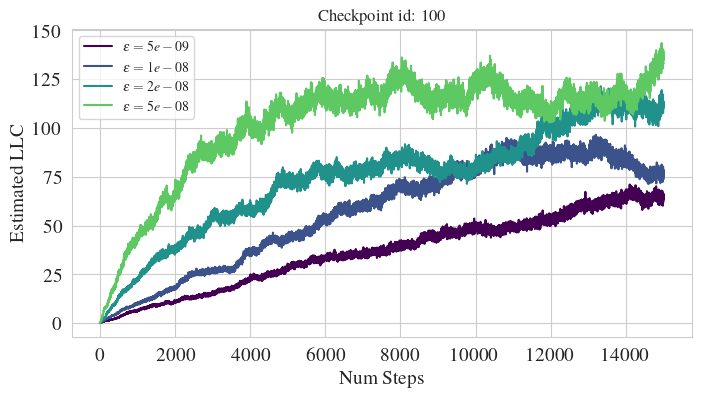

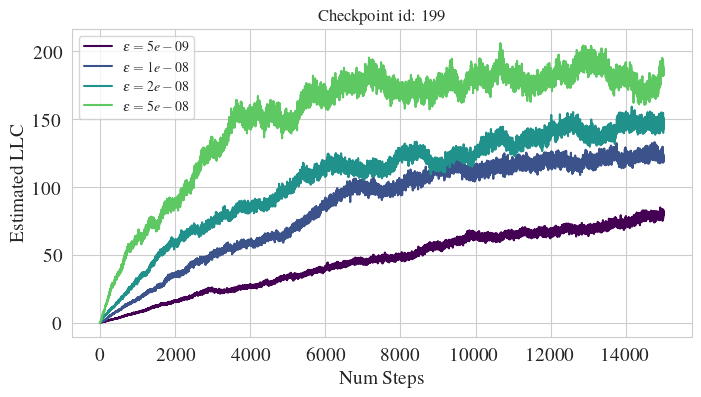

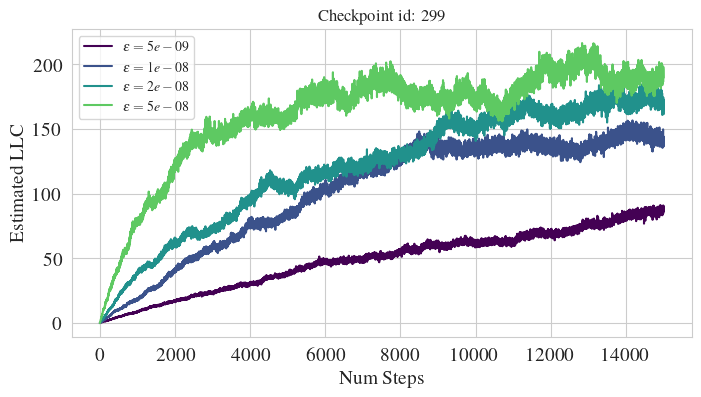

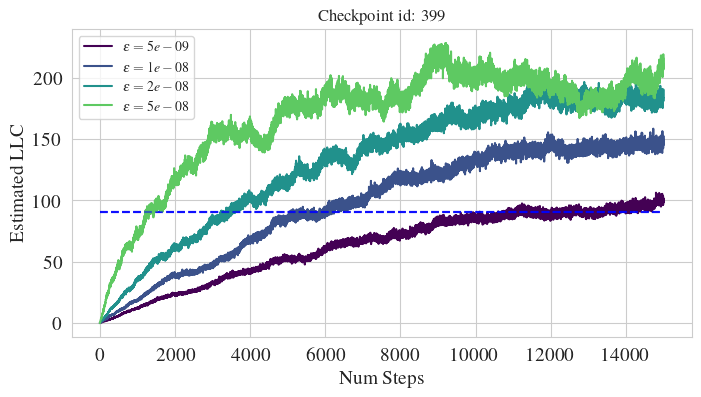

In [471]:

true_lambda = df["lambdahat"].iloc[-1]

for idx in sorted(set([a for a, _ in sgld_rec.keys()])):
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    epses = sorted(set([b for a, b in sgld_rec.keys() if a == idx]))
    _set_color_cycle(len(epses) + 1)
    for eps in epses:
        ax.plot(sgld_rec[(idx, eps)], label=f"$\epsilon={eps}$")
        if idx == df.shape[0] - 1:
            ax.hlines(true_lambda, 0, len(sgld_rec[(idx, eps)]), color="b", linestyle="--", alpha=0.5)
    ax.set_xlabel("Num Steps")
    ax.set_ylabel("Estimated LLC")
    ax.set_title(f"Checkpoint id: {idx}")
    ax.legend()

Initialising teacher matrix with config: {'type': 'band_power_law', 'config_vals': [5.0, 1.05, 2, 300]}
Teacher matrix shape: (256, 256)


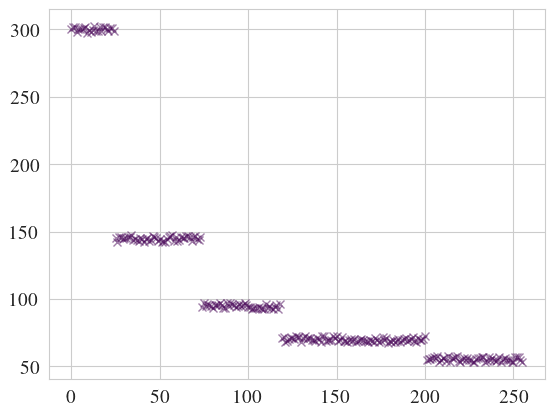

In [612]:


def init_teacher_matrix(
        input_dim, 
        output_dim, 
        config={"type":"diagonal", "config_vals":[50, 10]}
    ):
    teacher_matrix_type = config["type"]
    config_vals = config["config_vals"]
    if isinstance(config_vals, str):
        config_vals = ast.literal_eval(config_vals)
    print(f"Initialising teacher matrix with config: {config}")
    num_modes = min(input_dim, output_dim)
    if teacher_matrix_type == "band_power_law":
        bandwidth, power = config_vals[:2]
        if len(config_vals) == 3:
            num_group = config_vals[2]
        else:
            num_group = 3
        num_assigned_modes = 0
        index_groups = []
        while num_assigned_modes < num_modes:
            num_modes_in_band = np.random.randint(2, num_modes // min(num_group, num_modes))
            num_modes_in_band = min(num_modes_in_band, num_modes - num_assigned_modes)
            band_indices = list(range(num_assigned_modes, num_assigned_modes + num_modes_in_band))
            index_groups.append(band_indices)
            num_assigned_modes += num_modes_in_band
        if len(config_vals) == 4:
            max_val = config_vals[3]
        else:
            max_val = 20 * len(index_groups)
        spectra = np.zeros(num_modes)
        for i, band_indices in enumerate(index_groups):
            current_band_center = max_val * (i + 1) ** (-power)
            singular_values = np.random.uniform(current_band_center - bandwidth / 2, current_band_center + bandwidth / 2, len(band_indices))
            spectra[band_indices] = singular_values
        teacher_matrix = np.diag(spectra)
    else:
        raise ValueError(f"Unknown teacher matrix type: {teacher_matrix_type}")
    print(f"Teacher matrix shape: {teacher_matrix.shape}")
    return teacher_matrix[:input_dim, :output_dim]

mat = init_teacher_matrix(256, 256, config={"type": "band_power_law", "config_vals": [5.0, 1.05, 2, 300]})
spectrum = np.diag(mat)
plt.plot(spectrum, "x", alpha=0.5)